In [1]:
from models import FeedforwardNeuralNetModel, TinyCNN, PatternClassifier
import regularizer_losts as rl
from torchvision import datasets, transforms
from torch import optim
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import copy
import utils as CFI_utils
from matplotlib import pyplot as plt
import numpy as np
from collections import defaultdict
%matplotlib inline

import seaborn as sns
colors = sns.color_palette("tab10")

#Logging stuffs
import logging
import sys
# Create logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Create STDERR handler
handler = logging.StreamHandler(sys.stderr)
# ch.setLevel(logging.DEBUG)

# Create formatter and add it to the handler
formatter = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)

# Set STDERR handler as the only handler 
logger.handlers = [handler]


#configs
epochs = 10
batch_size = 1000
test_batch_size = 10000
use_cuda = True
lr = 0.01
log_interval = 100


#torch specific configs
torch.manual_seed(1)

device = torch.device("cuda")

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}

if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

## Agenda
### Big question: CFI for NN


Are we doing complete verification or fuzzing/testing?

What is a `CFI`?

# What is a good abstraction for a NN's structure? Can it be enforced through regularization?
- Distillation? (https://arxiv.org/pdf/1503.02531.pdf)
- Decision Tree? (https://arxiv.org/pdf/1711.09784.pdf)
- Model Extraction? (https://arxiv.org/pdf/2003.04884.pdf)


### Where are we?
We want to do CFI for NN

## Question: Do we want to verify each AP separately? Or we want to tell the difference between activation patterns of real images from fake one using a method M and verify M?



## Option 1: We want to verify each AP separately (we are here)
To be able to do so, we need

### Condition 1: The number of activation patterns for a neural networks has to be way smaller than the size of the training/test set.
#### Why: 

  If every input results in a different AP, given an AP, very likely during infer time every input will have its own AP, so we have to reject it

  We want to verify each AP separately, so smaller the number the better

#### Progress: 

  with the current regularization effort, we have been able to reduce the number of AP to about 20k for 60k input.

#### Aim: 

Reduce to about few hundreds

#### Tricky part: 

Given a network of N layers, we can limit the number of activation patterns by only looking at k < N layers. Question: which k? 

### Condition 2: All, or most, of the activation patterns of the test set has to be covered by the AP of the training set
#### Why: 
If the activation patterns in the test set are completely different from the training set, there would be too many false negative at the inferencing time
#### Progress: 
Possible, but with a big caveat: the fake AP is now also included in the set

### Condition 3: Given an adv exp, its AP cannot be in the training AP set.
#### Progress:
Currently, if Cond.2 is satisfied, then 3 is not.


## Option 2: Train the network s.t the fake AP and real AP can be separated by some methods (linear classifier or a small neural net)

## What are the state-of-the-art attacks and defences?


## Backlog RQs: 
- BRQ1: Can we look at a random k entries in the weight instead of the first k?
- BRQ2: What if we set all the small abs weight in the Pattern classifer to 0? what is the accuracy in that case?
- BRQ4: Given a simple attacking method (e.g, Fast gradient sign), build a dataset of activation maps of true and fake digits. Try to train a pattern classifier using that dataset.
- __BRQ5: Given a target and its corresponding adv. exp, can we gradually move in the in-between space to see at which point the label is changed?__




In [95]:
def check_gradient(grad, label, last_sorted_grads, plot = False):
    logging.info("CHECKING GRADIENT FOR LABEL {}".format(label))
    sum_abs_grad = np.sum(abs(grad[label]), axis = 0)
    
    current_sorted_grad = (-sum_abs_grad).argsort()
    
#     if len(last_sorted_grads[label]) > 0:
#         for k in [100, 200, 300, 400]:
#             prev_top_k = set(last_sorted_grads[label][-1][:k])
#             current_top_k = set(current_sorted_grad[:k])
#             intersect = prev_top_k.intersection(current_top_k)
#             logging.info('k = {}. How many top Gradients are stable since last epoch?: {}'.format(k, len(intersect)))
        
    for k in [0, 9, 99, 199]:    
        logging.debug('{}th biggest gradient = {}'.format(k, np.sort(-sum_abs_grad)[k]))
    if plot:
        fig = plt.figure(figsize=(30, 1))
        plt.bar(range(sum_abs_grad.shape[0]), sum_abs_grad)
        plt.show()
        print(sum_abs_grad.max(), sum_abs_grad.argmax(), sum_abs_grad.min())

    return current_sorted_grad



#init stuffs
LOAD = False
# LOADPATH = 'TinyCNNreg.conv1.conv2.fc1.fc2.17:09:00'
LOADPATH = 'TinyCNNreg.conv2.fc1.fc2.15:09:24'
# LOADPATH = 'TinyCNNreg.fc1.fc2.16:06:26'
LAST_N_EPOCHS = 10

dataset1 = datasets.MNIST('../data', train=True, download=True,
                          transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                          transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

model = FeedforwardNeuralNetModel(28*28, 128, 10).to(device)
# model = TinyCNN().to(device)
if LOAD:
    model.load_state_dict(torch.load(LOADPATH))
else:

    epochs = 30
    optimizer = optim.Adadelta(model.parameters(), lr=lr)

    scheduler = StepLR(optimizer, step_size=1, gamma = 0.7)
    last_sorted_grads = defaultdict(list)
    
    all_rows = []
    
    for epoch in tqdm(range(1, epochs + 1)):
        model.register_gradient()
        model.train()
        target_log  = None # need to record the label to match with the gradient later
        for data, target in train_loader:
            target_log = np.concatenate((target_log, target), axis = 0) if target_log is not None else target
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data.float())
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
        CFI_utils.test(model, device, test_loader)
#         scheduler.step()
        grad = CFI_utils.get_grad_each_label(model.gradient_log, 
                                      target_log = target_log, 
                                      layers = ['fc1', 'fc2', 'fc3', 'fc4'], 
                                      labels = range(10))
        torch.save(model.state_dict(), model.model_savename())
        
        row_data = []
        for label in range(10):
            r = []
            logging.info("After {} epoch:".format(epoch))
            last_sorted_grads[label].append(check_gradient(grad, label, last_sorted_grads))
            
            
            if epoch >= LAST_N_EPOCHS:
                for k in [100, 200, 300, 400]:
                    all_top_k = [set(sorted_grad[:k]) for sorted_grad in last_sorted_grads[label][-LAST_N_EPOCHS:]]
                    intersect = set.intersection(*all_top_k)
                    logging.info('k = {}. How many top Gradients are stable among all last {} epochs?: {}'.format(k, LAST_N_EPOCHS, len(intersect)))

  0%|          | 0/30 [00:00<?, ?it/s]root - INFO - After 1 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 0
root - INFO - After 1 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 1
root - INFO - After 1 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 2
root - INFO - After 1 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 3
root - INFO - After 1 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 4
root - INFO - After 1 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 5
root - INFO - After 1 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 6
root - INFO - After 1 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 7
root - INFO - After 1 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 8
root - INFO - After 1 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 9
  3%|▎         | 1/30 [00:18<09:09, 18.95s/it]


Test set: Average loss: 2.2824, Accuracy: 1229/10000 (12%)



root - INFO - After 2 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 0
root - INFO - After 2 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 1
root - INFO - After 2 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 2
root - INFO - After 2 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 3
root - INFO - After 2 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 4
root - INFO - After 2 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 5
root - INFO - After 2 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 6
root - INFO - After 2 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 7
root - INFO - After 2 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 8
root - INFO - After 2 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 9
  7%|▋         | 2/30 [00:37<08:50, 18.95s/it]


Test set: Average loss: 2.2520, Accuracy: 2461/10000 (25%)



root - INFO - After 3 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 0
root - INFO - After 3 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 1
root - INFO - After 3 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 2
root - INFO - After 3 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 3
root - INFO - After 3 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 4
root - INFO - After 3 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 5
root - INFO - After 3 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 6
root - INFO - After 3 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 7
root - INFO - After 3 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 8
root - INFO - After 3 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 9
 10%|█         | 3/30 [00:56<08:31, 18.96s/it]


Test set: Average loss: 2.2055, Accuracy: 4041/10000 (40%)



root - INFO - After 4 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 0
root - INFO - After 4 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 1
root - INFO - After 4 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 2
root - INFO - After 4 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 3
root - INFO - After 4 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 4
root - INFO - After 4 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 5
root - INFO - After 4 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 6
root - INFO - After 4 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 7
root - INFO - After 4 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 8
root - INFO - After 4 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 9
 13%|█▎        | 4/30 [01:15<08:12, 18.95s/it]


Test set: Average loss: 2.1264, Accuracy: 4767/10000 (48%)



root - INFO - After 5 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 0
root - INFO - After 5 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 1
root - INFO - After 5 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 2
root - INFO - After 5 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 3
root - INFO - After 5 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 4
root - INFO - After 5 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 5
root - INFO - After 5 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 6
root - INFO - After 5 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 7
root - INFO - After 5 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 8
root - INFO - After 5 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 9
 17%|█▋        | 5/30 [01:34<07:54, 18.98s/it]


Test set: Average loss: 1.9888, Accuracy: 4810/10000 (48%)



root - INFO - After 6 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 0
root - INFO - After 6 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 1
root - INFO - After 6 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 2
root - INFO - After 6 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 3
root - INFO - After 6 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 4
root - INFO - After 6 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 5
root - INFO - After 6 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 6
root - INFO - After 6 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 7
root - INFO - After 6 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 8
root - INFO - After 6 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 9
 20%|██        | 6/30 [01:53<07:34, 18.93s/it]


Test set: Average loss: 1.7715, Accuracy: 5217/10000 (52%)



root - INFO - After 7 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 0
root - INFO - After 7 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 1
root - INFO - After 7 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 2
root - INFO - After 7 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 3
root - INFO - After 7 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 4
root - INFO - After 7 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 5
root - INFO - After 7 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 6
root - INFO - After 7 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 7
root - INFO - After 7 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 8
root - INFO - After 7 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 9
 23%|██▎       | 7/30 [02:12<07:15, 18.94s/it]


Test set: Average loss: 1.4886, Accuracy: 6385/10000 (64%)



root - INFO - After 8 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 0
root - INFO - After 8 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 1
root - INFO - After 8 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 2
root - INFO - After 8 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 3
root - INFO - After 8 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 4
root - INFO - After 8 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 5
root - INFO - After 8 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 6
root - INFO - After 8 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 7
root - INFO - After 8 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 8
root - INFO - After 8 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 9
 27%|██▋       | 8/30 [02:31<06:57, 18.97s/it]


Test set: Average loss: 1.1968, Accuracy: 7233/10000 (72%)



root - INFO - After 9 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 0
root - INFO - After 9 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 1
root - INFO - After 9 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 2
root - INFO - After 9 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 3
root - INFO - After 9 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 4
root - INFO - After 9 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 5
root - INFO - After 9 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 6
root - INFO - After 9 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 7
root - INFO - After 9 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 8
root - INFO - After 9 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 9
 30%|███       | 9/30 [02:50<06:38, 18.99s/it]


Test set: Average loss: 0.9702, Accuracy: 7757/10000 (78%)



root - INFO - After 10 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 0
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 64
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 120
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 235
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 363
root - INFO - After 10 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 1
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 56
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 129
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 218
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 364
root - INFO - After 10 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 2
root - INFO - k = 100. How many top Gradients are stable among all last 10 e


Test set: Average loss: 0.8164, Accuracy: 8037/10000 (80%)



root - INFO - CHECKING GRADIENT FOR LABEL 7
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 57
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 131
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 230
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 363
root - INFO - After 10 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 8
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 69
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 135
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 227
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 365
root - INFO - After 10 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 9
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 66
root - INFO - k = 2


Test set: Average loss: 0.7104, Accuracy: 8235/10000 (82%)



root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 61
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 135
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 239
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 366
root - INFO - After 11 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 8
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 70
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 135
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 231
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 368
root - INFO - After 11 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 9
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 70
root - INFO - k = 200. How many top Gradients are stable among 


Test set: Average loss: 0.6359, Accuracy: 8367/10000 (84%)



root - INFO - After 12 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 7
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 65
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 136
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 244
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 367
root - INFO - After 12 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 8
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 71
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 138
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 239
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 373
root - INFO - After 12 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 9
root - INFO - k = 100. How many top Gradients are stable among all last 10 e


Test set: Average loss: 0.5804, Accuracy: 8485/10000 (85%)



root - INFO - CHECKING GRADIENT FOR LABEL 7
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 66
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 140
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 248
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 372
root - INFO - After 13 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 8
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 71
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 144
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 245
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 378
root - INFO - After 13 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 9
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 69
root - INFO - k = 2


Test set: Average loss: 0.5378, Accuracy: 8564/10000 (86%)



root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 146
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 255
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 378
root - INFO - After 14 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 8
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 75
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 151
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 250
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 381
root - INFO - After 14 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 9
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 72
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 153
root - INFO - k = 300. How many top Gradients are stable among


Test set: Average loss: 0.5033, Accuracy: 8640/10000 (86%)



root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 73
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 151
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 259
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 380
root - INFO - After 15 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 8
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 78
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 151
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 257
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 385
root - INFO - After 15 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 9
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 73
root - INFO - k = 200. How many top Gradients are stable among 


Test set: Average loss: 0.4760, Accuracy: 8706/10000 (87%)



root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 268
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 383
root - INFO - After 16 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 7
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 74
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 158
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 265
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 381
root - INFO - After 16 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 8
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 78
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 159
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 264
root - INFO - k = 400. How many top Gradients are stable among


Test set: Average loss: 0.4530, Accuracy: 8756/10000 (88%)



root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 271
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 390
root - INFO - After 17 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 9
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 76
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 169
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 265
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 387
 57%|█████▋    | 17/30 [05:22<04:06, 18.98s/it]root - INFO - After 18 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 0
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 78
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 172
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 278
root - INFO - k


Test set: Average loss: 0.4339, Accuracy: 8800/10000 (88%)



root - INFO - After 18 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 8
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 81
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 169
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 276
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 394
root - INFO - After 18 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 9
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 76
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 168
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 273
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 390
 60%|██████    | 18/30 [05:41<03:47, 18.99s/it]root - INFO - After 19 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 0
root - INFO - k = 100. How ma


Test set: Average loss: 0.4176, Accuracy: 8839/10000 (88%)



root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 82
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 173
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 280
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 396
root - INFO - After 19 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 9
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 82
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 173
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 281
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 390
 63%|██████▎   | 19/30 [06:00<03:28, 19.00s/it]root - INFO - After 20 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 0
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 79
root - INFO - k 


Test set: Average loss: 0.4028, Accuracy: 8890/10000 (89%)



root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 184
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 287
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 391
root - INFO - After 20 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 8
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 85
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 181
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 284
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 397
root - INFO - After 20 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 9
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 86
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 179
root - INFO - k = 300. How many top Gradients are stable among


Test set: Average loss: 0.3909, Accuracy: 8909/10000 (89%)



root - INFO - After 21 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 8
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 86
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 183
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 285
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 396
root - INFO - After 21 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 9
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 88
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 183
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 285
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 393
 70%|███████   | 21/30 [06:38<02:50, 18.98s/it]root - INFO - After 22 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 0
root - INFO - k = 100. How ma


Test set: Average loss: 0.3803, Accuracy: 8924/10000 (89%)



root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 90
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 188
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 291
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 394
root - INFO - After 22 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 8
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 89
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 185
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 285
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 395
root - INFO - After 22 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 9
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 90
root - INFO - k = 200. How many top Gradients are stable among 


Test set: Average loss: 0.3705, Accuracy: 8943/10000 (89%)



root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 90
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 188
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 292
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 396
root - INFO - After 23 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 8
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 88
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 186
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 286
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 395
root - INFO - After 23 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 9
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 89
root - INFO - k = 200. How many top Gradients are stable among 


Test set: Average loss: 0.3620, Accuracy: 8966/10000 (90%)



root - INFO - After 24 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 7
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 92
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 188
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 292
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 396
root - INFO - After 24 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 8
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 89
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 186
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 288
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 395
root - INFO - After 24 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 9
root - INFO - k = 100. How many top Gradients are stable among all last 10 e


Test set: Average loss: 0.3543, Accuracy: 8983/10000 (90%)



root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 95
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 190
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 293
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 397
root - INFO - After 25 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 8
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 91
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 188
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 289
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 396
root - INFO - After 25 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 9
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 92
root - INFO - k = 200. How many top Gradients are stable among 


Test set: Average loss: 0.3473, Accuracy: 8996/10000 (90%)



root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 96
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 191
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 293
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 399
root - INFO - After 26 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 8
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 92
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 188
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 290
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 396
root - INFO - After 26 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 9
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 92
root - INFO - k = 200. How many top Gradients are stable among 


Test set: Average loss: 0.3413, Accuracy: 8998/10000 (90%)



root - INFO - After 27 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 7
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 96
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 192
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 295
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 398
root - INFO - After 27 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 8
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 92
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 189
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 290
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 397
root - INFO - After 27 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 9
root - INFO - k = 100. How many top Gradients are stable among all last 10 e


Test set: Average loss: 0.3349, Accuracy: 9024/10000 (90%)



root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 95
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 192
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 295
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 398
root - INFO - After 28 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 8
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 94
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 192
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 290
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 397
root - INFO - After 28 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 9
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 94
root - INFO - k = 200. How many top Gradients are stable among 


Test set: Average loss: 0.3297, Accuracy: 9040/10000 (90%)



root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 395
root - INFO - After 29 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 7
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 95
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 192
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 295
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 398
root - INFO - After 29 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 8
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 95
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 192
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 291
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 396
root - INFO - After 29 epoch:
root - INFO - CHECKING GRADIENT 


Test set: Average loss: 0.3242, Accuracy: 9056/10000 (91%)



root - INFO - CHECKING GRADIENT FOR LABEL 8
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 96
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 193
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 293
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 397
root - INFO - After 30 epoch:
root - INFO - CHECKING GRADIENT FOR LABEL 9
root - INFO - k = 100. How many top Gradients are stable among all last 10 epochs?: 94
root - INFO - k = 200. How many top Gradients are stable among all last 10 epochs?: 194
root - INFO - k = 300. How many top Gradients are stable among all last 10 epochs?: 293
root - INFO - k = 400. How many top Gradients are stable among all last 10 epochs?: 397
100%|██████████| 30/30 [09:29<00:00, 18.99s/it]


In [13]:



label = 1
for k in [100]:
    all_top_k = [set(sorted_grad[:k]) for sorted_grad in last_sorted_grads[label][-LAST_N_EPOCHS:]]
    intersect_0 = set.intersection(*all_top_k)
    print(intersect_0)
    print(len(intersect_0))

label = 7
for k in [100]:
    all_top_k = [set(sorted_grad[:k]) for sorted_grad in last_sorted_grads[label][-LAST_N_EPOCHS:]]
    intersect_1 = set.intersection(*all_top_k)
    print(intersect_1)
    print(len(intersect_1))
    
print(intersect_0.intersection(intersect_1))

{1, 8, 13, 26, 27, 33, 56, 79, 81, 88, 91, 99, 105, 150, 151, 158, 159, 162, 173, 176, 194, 212, 219, 238, 249, 256, 258, 259, 263, 264, 270, 285, 295, 299, 302, 306, 307, 315, 320, 328, 332, 340, 341, 344, 347, 349, 351, 352, 356, 358, 360, 364, 365, 366, 367, 373, 378, 380, 383, 384, 387, 390, 391, 393, 395, 396, 400, 404, 406, 407, 408, 410, 412, 413, 415, 416, 417, 419, 421, 422, 423, 426, 427, 429, 430, 433, 434, 435, 437, 438, 446, 447, 449, 450, 451, 456}
96
{7, 17, 26, 27, 32, 49, 51, 55, 59, 84, 86, 97, 102, 106, 119, 131, 173, 179, 189, 192, 201, 207, 216, 219, 228, 229, 235, 238, 249, 256, 261, 264, 265, 276, 277, 283, 284, 285, 289, 295, 302, 306, 309, 310, 314, 320, 321, 330, 339, 340, 341, 347, 352, 353, 356, 357, 358, 364, 366, 367, 371, 388, 389, 391, 394, 395, 396, 400, 402, 404, 405, 406, 407, 410, 416, 417, 419, 420, 421, 422, 423, 424, 426, 427, 436, 437, 438, 439, 441, 443, 450, 452, 455, 457}
94
{256, 391, 264, 395, 396, 400, 404, 406, 407, 26, 27, 410, 285, 416, 

# Study stable gradients

In [96]:
layers = ['fc1', 'fc2', 'fc3', 'fc4']
labels = range(10)
K = 25

all_patterns = {}

all_rows = []

for K in [25, 50, 100]:
    print("K=", K)
    row = []
    row.append(str(K))
    for label in labels:
        patterns = []
        #construct the stable gradients 
        all_top_k = [set(sorted_grad[:K]) for sorted_grad in last_sorted_grads[label][-LAST_N_EPOCHS:]]
        intersect = set.intersection(*all_top_k)
        stable_grad = np.array(sorted(list(intersect)))
        print("There are {} stable grad in top K".format(len(stable_grad)))
        print(stable_grad)


        for data, target in train_loader:
            filter_ids = target == label
            data = data[filter_ids]
            logging.debug(data.shape[0])
            pattern = CFI_utils.get_pattern(model, device, data)
            pattern = np.concatenate([pattern[l] for l in layers], axis = 1)
            logging.debug(pattern.shape)
            patterns.append(pattern)

        patterns = np.concatenate(patterns, axis = 0)
        all_patterns[label] = patterns
        logging.info(patterns.shape)
        print("LABEL:", label)
        print("how many unique paths in the full pattern?", np.unique(patterns, axis = 0).shape)
        print("how many unique paths in the filtered pattern?", np.unique(patterns[:, stable_grad ], axis = 0).shape)
        print("how many unique paths in the randomly filtered pattern?", 
              np.unique(patterns[:, 
                                 np.random.choice(458, len(stable_grad), replace = False) ], axis = 0).shape)
        row.append("|".join([str(len(stable_grad)),
                             str(np.unique(patterns, axis = 0).shape[0]),
                             str(np.unique(patterns[:, stable_grad ], axis = 0).shape[0]),
                             str(np.unique(patterns[:, np.random.choice(458, len(stable_grad), replace = False) ], axis = 0).shape[0])
                            ]))
    all_rows.append(",".join(row)+"\n")

with open("gradient_exp_log.csv", "w") as f:
    f.write("K,"+",".join([str(l) for l in labels]) + "\n")
    f.writelines(all_rows)

                   

K= 25
There are 23 stable grad in top K
[ 59 232 293 321 345 349 350 353 358 364 384 397 412 423 425 432 434 438
 439 441 447 448 453]


root - INFO - (5923, 458)


LABEL: 0
how many unique paths in the full pattern? (5923, 458)
how many unique paths in the filtered pattern? (168, 23)
how many unique paths in the randomly filtered pattern? (1023, 23)
There are 25 stable grad in top K
[232 266 275 291 331 353 354 358 371 384 385 391 396 397 416 418 421 422
 434 436 445 446 449 450 456]


root - INFO - (6742, 458)


LABEL: 1
how many unique paths in the full pattern? (6742, 458)
how many unique paths in the filtered pattern? (173, 25)
how many unique paths in the randomly filtered pattern? (723, 25)
There are 24 stable grad in top K
[261 318 331 339 352 377 393 410 411 414 420 422 426 428 429 435 439 443
 444 446 450 451 454 456]


root - INFO - (5958, 458)


LABEL: 2
how many unique paths in the full pattern? (5958, 458)
how many unique paths in the filtered pattern? (311, 24)
how many unique paths in the randomly filtered pattern? (565, 24)
There are 22 stable grad in top K
[257 323 331 356 362 393 394 398 400 406 417 419 429 435 437 441 443 447
 450 451 453 456]


root - INFO - (6131, 458)


LABEL: 3
how many unique paths in the full pattern? (6131, 458)
how many unique paths in the filtered pattern? (303, 22)
how many unique paths in the randomly filtered pattern? (1536, 22)
There are 22 stable grad in top K
[ 93 263 279 287 295 366 375 378 384 386 393 394 395 400 406 409 414 420
 434 440 452 457]


root - INFO - (5842, 458)


LABEL: 4
how many unique paths in the full pattern? (5842, 458)
how many unique paths in the filtered pattern? (176, 22)
how many unique paths in the randomly filtered pattern? (476, 22)
There are 23 stable grad in top K
[156 280 318 331 384 394 397 406 409 414 419 421 423 429 433 434 435 443
 447 451 453 454 456]


root - INFO - (5421, 458)


LABEL: 5
how many unique paths in the full pattern? (5421, 458)
how many unique paths in the filtered pattern? (215, 23)
how many unique paths in the randomly filtered pattern? (746, 23)
There are 23 stable grad in top K
[183 274 289 319 323 369 378 381 384 405 407 411 416 437 438 440 441 444
 447 450 452 453 454]


root - INFO - (5918, 458)


LABEL: 6
how many unique paths in the full pattern? (5918, 458)
how many unique paths in the filtered pattern? (153, 23)
how many unique paths in the randomly filtered pattern? (552, 23)
There are 22 stable grad in top K
[ 13  61  87 115 176 312 350 354 357 371 385 393 394 395 415 419 425 426
 433 437 455 457]


root - INFO - (6265, 458)


LABEL: 7
how many unique paths in the full pattern? (6265, 458)
how many unique paths in the filtered pattern? (91, 22)
how many unique paths in the randomly filtered pattern? (1411, 22)
There are 23 stable grad in top K
[156 241 278 349 377 393 397 411 414 419 422 425 428 432 437 438 443 444
 450 451 453 456 457]


root - INFO - (5851, 458)


LABEL: 8
how many unique paths in the full pattern? (5851, 458)
how many unique paths in the filtered pattern? (309, 23)
how many unique paths in the randomly filtered pattern? (791, 23)
There are 23 stable grad in top K
[315 350 366 371 387 393 395 400 406 411 420 421 422 423 425 433 434 436
 437 440 452 455 457]


root - INFO - (5949, 458)


LABEL: 9
how many unique paths in the full pattern? (5949, 458)
how many unique paths in the filtered pattern? (109, 23)
how many unique paths in the randomly filtered pattern? (395, 23)
K= 50
There are 46 stable grad in top K
[ 39  44  59  72 102 106 225 232 268 270 280 293 306 321 345 349 350 353
 356 358 361 363 364 377 384 397 405 411 412 421 423 425 428 429 432 433
 434 438 439 441 443 444 447 448 450 453]


root - INFO - (5923, 458)


LABEL: 0
how many unique paths in the full pattern? (5923, 458)
how many unique paths in the filtered pattern? (874, 46)
how many unique paths in the randomly filtered pattern? (3415, 46)
There are 49 stable grad in top K
[ 23 115 124 159 171 172 232 245 266 268 271 275 279 284 291 311 322 331
 340 349 352 353 354 358 371 379 384 385 391 396 397 408 409 416 418 421
 422 426 434 436 437 439 445 446 447 449 450 451 456]


root - INFO - (6742, 458)


LABEL: 1
how many unique paths in the full pattern? (6742, 458)
how many unique paths in the filtered pattern? (295, 49)
how many unique paths in the randomly filtered pattern? (1939, 49)
There are 49 stable grad in top K
[ 26  77  91 133 186 219 232 257 261 274 318 328 331 339 350 352 356 361
 371 377 384 393 397 398 409 410 411 414 417 419 420 422 423 426 428 429
 434 435 438 439 443 444 446 449 450 451 452 454 456]


root - INFO - (5958, 458)


LABEL: 2
how many unique paths in the full pattern? (5958, 458)
how many unique paths in the filtered pattern? (1463, 49)
how many unique paths in the randomly filtered pattern? (3459, 49)
There are 46 stable grad in top K
[ 64 128 143 189 210 212 227 257 268 269 281 302 321 323 331 342 356 362
 365 382 387 393 394 398 400 401 406 417 419 421 425 428 429 432 433 435
 437 438 439 441 443 447 450 451 453 456]


root - INFO - (6131, 458)


LABEL: 3
how many unique paths in the full pattern? (6131, 458)
how many unique paths in the filtered pattern? (1612, 46)
how many unique paths in the randomly filtered pattern? (5212, 46)
There are 46 stable grad in top K
[ 30  54  93 105 176 183 233 253 261 263 264 278 279 287 295 301 323 333
 352 366 369 370 375 378 384 386 390 391 393 394 395 397 398 400 406 409
 414 419 420 434 436 440 441 443 452 457]


root - INFO - (5842, 458)


LABEL: 4
how many unique paths in the full pattern? (5842, 458)
how many unique paths in the filtered pattern? (538, 46)
how many unique paths in the randomly filtered pattern? (3638, 46)
There are 47 stable grad in top K
[156 161 186 187 229 262 280 281 287 318 331 339 349 350 371 376 383 384
 385 391 394 395 397 398 401 406 409 412 414 419 420 421 422 423 429 433
 434 435 439 442 443 447 448 451 453 454 456]


root - INFO - (5421, 458)


LABEL: 5
how many unique paths in the full pattern? (5421, 458)
how many unique paths in the filtered pattern? (736, 47)
how many unique paths in the randomly filtered pattern? (4330, 47)
There are 46 stable grad in top K
[ 45  65  95 133 162 183 212 255 265 274 289 301 310 319 323 357 364 369
 378 381 384 394 398 404 405 406 407 409 411 416 417 426 437 438 440 441
 442 443 444 447 448 450 452 453 454 456]


root - INFO - (5918, 458)


LABEL: 6
how many unique paths in the full pattern? (5918, 458)
how many unique paths in the filtered pattern? (1164, 46)
how many unique paths in the randomly filtered pattern? (5019, 46)
There are 49 stable grad in top K
[ 13  26  61  80  87 106 115 117 150 176 183 190 256 266 271 281 294 304
 312 319 323 339 349 350 354 357 359 371 372 379 383 384 385 393 394 395
 397 411 415 419 425 426 433 434 436 437 442 455 457]


root - INFO - (6265, 458)


LABEL: 7
how many unique paths in the full pattern? (6265, 458)
how many unique paths in the filtered pattern? (1317, 49)
how many unique paths in the randomly filtered pattern? (3982, 49)
There are 48 stable grad in top K
[109 156 241 264 277 278 310 317 328 331 346 347 349 360 377 379 384 385
 390 393 397 398 402 411 414 419 420 422 423 425 428 429 432 434 435 436
 437 438 439 443 444 446 449 450 451 453 456 457]


root - INFO - (5851, 458)


LABEL: 8
how many unique paths in the full pattern? (5851, 458)
how many unique paths in the filtered pattern? (788, 48)
how many unique paths in the randomly filtered pattern? (3961, 48)
There are 46 stable grad in top K
[105 109 156 278 284 306 307 310 315 342 350 354 357 366 370 371 384 386
 387 393 394 395 398 400 402 406 411 415 419 420 421 422 423 425 426 429
 432 433 434 436 437 440 452 455 456 457]


root - INFO - (5949, 458)


LABEL: 9
how many unique paths in the full pattern? (5949, 458)
how many unique paths in the filtered pattern? (622, 46)
how many unique paths in the randomly filtered pattern? (2775, 46)
K= 100
There are 96 stable grad in top K
[ 13  23  26  39  44  59  72 102 106 110 115 138 159 171 172 173 176 186
 190 200 209 216 225 227 229 232 239 241 257 259 262 267 268 270 273 275
 280 293 296 306 307 310 313 318 321 322 331 345 346 349 350 353 356 358
 361 363 364 365 369 372 377 378 379 384 391 393 395 397 402 403 405 409
 411 412 416 417 421 423 425 428 429 432 433 434 435 438 439 441 443 444
 447 448 450 453 454 456]


root - INFO - (5923, 458)


LABEL: 0
how many unique paths in the full pattern? (5923, 458)
how many unique paths in the filtered pattern? (3489, 96)
how many unique paths in the randomly filtered pattern? (5721, 96)
There are 97 stable grad in top K
[  0   4  14  23  36  44  45  47  76  91  95  99 100 113 115 119 124 150
 159 171 172 176 186 199 232 244 245 249 253 265 266 267 268 271 275 277
 279 280 284 291 304 311 314 317 322 325 331 340 344 345 349 350 351 352
 353 354 358 361 364 368 371 375 379 381 384 385 390 391 394 395 396 397
 408 409 416 418 419 421 422 423 426 433 434 435 436 437 439 444 445 446
 447 449 450 451 453 455 456]


root - INFO - (6742, 458)


LABEL: 1
how many unique paths in the full pattern? (6742, 458)
how many unique paths in the filtered pattern? (2086, 97)
how many unique paths in the randomly filtered pattern? (5632, 97)
There are 92 stable grad in top K
[  9  23  26  45  77  79  91 102 103 121 133 137 139 151 161 172 186 187
 188 204 214 219 232 248 251 257 261 262 265 274 281 284 285 289 294 310
 318 321 327 328 331 332 339 350 352 355 356 358 359 361 371 372 375 377
 381 384 387 393 394 395 396 397 398 409 410 411 414 417 418 419 420 422
 423 426 428 429 432 434 435 437 438 439 443 444 446 449 450 451 452 454
 455 456]


root - INFO - (5958, 458)


LABEL: 2
how many unique paths in the full pattern? (5958, 458)
how many unique paths in the filtered pattern? (4446, 92)
how many unique paths in the randomly filtered pattern? (5951, 92)
There are 94 stable grad in top K
[ 16  19  38  44  64  94  97 103 115 128 143 156 161 162 169 186 189 202
 204 210 212 227 254 256 257 268 269 280 281 284 298 302 303 318 321 323
 326 328 331 332 337 339 340 342 346 347 349 355 356 360 362 365 371 379
 382 383 385 387 393 394 396 398 400 401 406 410 412 417 419 420 421 423
 425 426 428 429 432 433 434 435 436 437 438 439 440 441 443 447 450 451
 453 455 456 457]


root - INFO - (6131, 458)


LABEL: 3
how many unique paths in the full pattern? (6131, 458)
how many unique paths in the filtered pattern? (3961, 94)
how many unique paths in the randomly filtered pattern? (6126, 94)
There are 93 stable grad in top K
[ 30  52  54  65  87  91  93  94 105 109 115 146 153 161 172 176 179 183
 184 193 214 233 240 250 253 261 263 264 265 266 275 278 279 281 282 283
 284 287 295 301 304 306 310 314 318 322 323 325 333 351 352 359 366 369
 370 375 378 379 384 386 390 391 393 394 395 397 398 400 405 406 409 411
 414 417 419 420 423 425 428 429 432 434 435 436 437 440 441 443 447 452
 454 456 457]


root - INFO - (5842, 458)


LABEL: 4
how many unique paths in the full pattern? (5842, 458)
how many unique paths in the filtered pattern? (2633, 93)
how many unique paths in the randomly filtered pattern? (5614, 93)
There are 96 stable grad in top K
[  2  13  26  33  45  61  72 109 115 137 139 156 161 167 176 186 187 193
 209 218 219 229 239 257 262 266 273 275 277 280 281 285 287 302 317 318
 322 331 336 339 349 350 353 354 356 368 369 370 371 376 383 384 385 391
 393 394 395 397 398 400 401 405 406 407 409 410 412 414 417 419 420 421
 422 423 426 428 429 432 433 434 435 437 438 439 440 442 443 446 447 448
 451 452 453 454 456 457]


root - INFO - (5421, 458)


LABEL: 5
how many unique paths in the full pattern? (5421, 458)
how many unique paths in the filtered pattern? (3811, 96)
how many unique paths in the randomly filtered pattern? (5411, 96)
There are 97 stable grad in top K
[  1  19  25  33  40  45  64  65  80  95 105 115 133 148 156 162 163 167
 183 186 190 203 210 212 217 236 250 254 255 257 259 265 268 274 281 283
 289 293 301 303 304 310 318 319 323 331 338 342 350 351 356 357 361 364
 368 369 378 381 384 386 394 395 398 404 405 406 407 409 410 411 412 416
 417 419 420 421 423 425 426 429 434 435 437 438 439 440 441 442 443 444
 447 448 450 452 453 454 456]


root - INFO - (5918, 458)


LABEL: 6
how many unique paths in the full pattern? (5918, 458)
how many unique paths in the filtered pattern? (4612, 97)
how many unique paths in the randomly filtered pattern? (5895, 97)
There are 96 stable grad in top K
[  0  13  26  30  61  65  74  80  87  91 106 115 117 133 144 146 150 152
 176 183 190 194 217 219 220 221 240 255 256 259 265 266 270 271 281 284
 294 304 305 312 315 319 322 323 325 334 339 342 346 349 350 354 356 357
 359 363 368 371 372 379 383 384 385 393 394 395 397 400 402 406 409 410
 411 412 415 419 420 422 425 426 429 432 433 434 435 436 437 439 442 443
 446 449 450 452 455 457]


root - INFO - (6265, 458)


LABEL: 7
how many unique paths in the full pattern? (6265, 458)
how many unique paths in the filtered pattern? (4432, 96)
how many unique paths in the randomly filtered pattern? (6168, 96)
There are 96 stable grad in top K
[  2  13  19  74  80  93  96 100 109 115 144 156 160 194 218 219 228 229
 241 257 262 263 264 268 269 270 277 278 280 284 291 302 306 307 310 317
 323 328 330 331 342 345 346 347 349 350 352 356 358 360 364 371 372 375
 376 377 379 382 384 385 386 390 391 393 394 397 398 402 411 414 417 419
 420 422 423 425 428 429 432 434 435 436 437 438 439 441 443 444 446 449
 450 451 453 454 456 457]


root - INFO - (5851, 458)


LABEL: 8
how many unique paths in the full pattern? (5851, 458)
how many unique paths in the filtered pattern? (3780, 96)
how many unique paths in the randomly filtered pattern? (5653, 96)
There are 94 stable grad in top K
[ 30  40  51  61  65  84  87  93 105 109 115 117 129 150 156 168 176 183
 188 227 240 256 259 266 273 274 275 278 280 284 295 306 307 310 312 315
 321 323 333 342 346 350 354 355 357 363 366 370 371 378 379 384 385 386
 387 390 393 394 395 397 398 400 402 403 405 406 409 411 412 414 415 417
 419 420 421 422 423 425 426 429 432 433 434 435 436 437 440 442 447 452
 453 455 456 457]


root - INFO - (5949, 458)


LABEL: 9
how many unique paths in the full pattern? (5949, 458)
how many unique paths in the filtered pattern? (2208, 94)
how many unique paths in the randomly filtered pattern? (5764, 94)


# Study stable ReLUs

(5923, 458)
how many unique paths in the filtered pattern? (38, 98)
[258 276 288 297 299 308 335 348 373 388 389 392 399 413 424 430 449   4
  11  13  36  39  41  62  72  80 106 115 129 138 159 167 181 186 187 188
 190 220 223 225 232 257 259 265 266 269 270 273 274 278 280 283 303 310
 314 315 322 331 337 339 345 347 350 351 352 353 355 358 360 361 366 368
 371 375 377 383 385 387 391 397 398 404 405 406 407 412 414 417 425 426
 428 429 434 435 436 437 438 443]


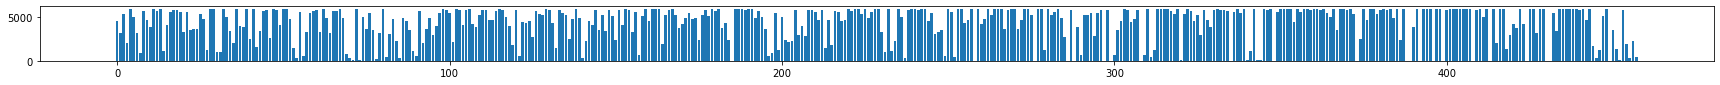

5923
(6742, 458)
how many unique paths in the filtered pattern? (51, 142)
[ 31 196 286 288 297 299 308 309 335 348 373 389 392 399 430 431 448   0
   8  14  23  26  29  44  59  60  64  65  67  76  80  88  95  97 100 113
 114 124 137 153 156 171 172 173 176 180 183 188 194 200 210 216 220 221
 227 241 244 245 247 250 251 256 257 261 262 265 266 267 268 269 271 273
 274 275 278 279 281 283 285 287 291 293 294 298 304 306 314 315 318 319
 321 322 328 332 333 337 339 340 346 347 349 350 351 354 356 357 360 361
 364 365 369 370 372 376 378 379 382 384 387 393 394 398 400 405 407 409
 414 418 419 420 423 432 433 436 437 439 440 441 442 444 446 447]


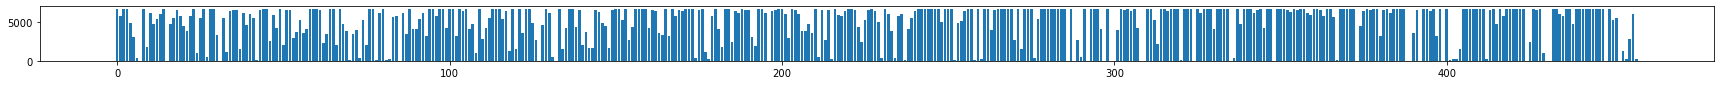

6742
(5958, 458)
how many unique paths in the filtered pattern? (40, 58)
[286 288 299 308 348 373 389 392 399 430 431  44  67  80 100 180 188 216
 227 257 265 266 268 269 273 274 283 304 306 314 315 317 318 319 322 333
 339 346 347 349 351 352 360 361 368 376 384 385 387 391 409 417 422 423
 426 434 436 441]


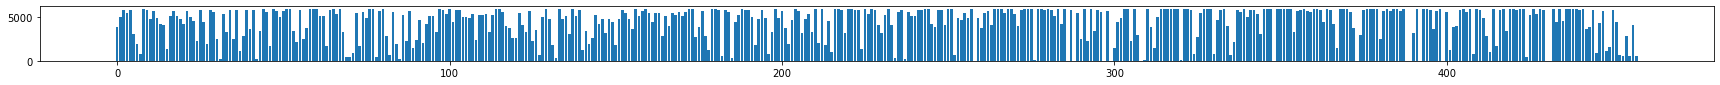

5958
(6131, 458)
how many unique paths in the filtered pattern? (47, 89)
[258 276 288 297 299 308 320 335 348 373 389 392 399 430  29  44  59  80
 100 129 137 159 162 167 180 188 198 200 210 216 227 228 232 261 262 265
 266 268 269 273 275 280 281 283 304 306 310 314 315 319 321 322 329 331
 332 337 339 347 349 351 352 353 355 356 358 361 362 368 369 378 379 384
 385 387 391 393 394 398 400 405 407 414 416 423 436 439 440 441 447]


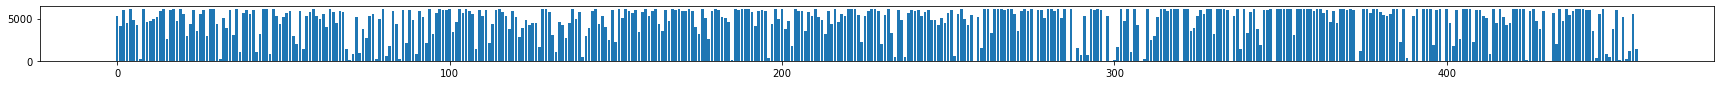

6131
(5842, 458)
how many unique paths in the filtered pattern? (46, 108)
[258 286 288 290 297 299 309 373 388 389 392 399 424 430 431  52  61  80
  91  93 115 146 156 161 173 183 184 201 212 216 220 221 227 233 250 253
 259 261 263 265 267 268 269 273 275 279 280 282 285 287 298 301 303 304
 306 307 310 314 315 317 318 319 322 323 333 346 347 350 351 352 353 357
 358 359 361 364 365 368 371 375 376 381 382 383 384 385 390 391 393 395
 397 405 407 409 416 417 419 421 423 426 428 432 435 436 439 443 444 447]


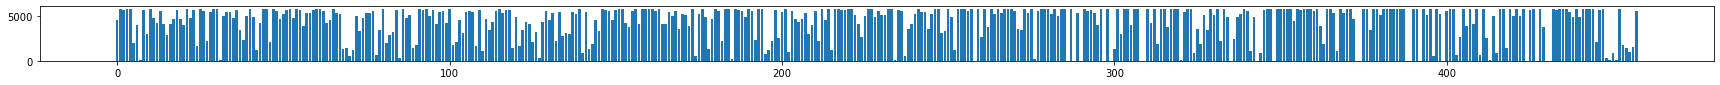

5842
(5421, 458)
how many unique paths in the filtered pattern? (40, 67)
[286 288 297 299 308 335 348 373 388 389 392 399 424 430  29  36  45  80
 115 159 187 216 232 257 261 265 266 268 269 273 280 287 298 310 314 315
 322 331 345 347 349 350 351 352 353 355 358 361 368 369 371 375 378 383
 384 385 387 391 398 405 407 417 436 439 441 443 447]


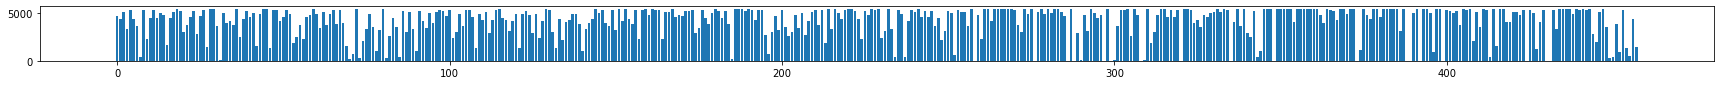

5421
(5918, 458)
how many unique paths in the filtered pattern? (40, 118)
[258 286 288 299 308 309 373 388 389 392 399 415 424 430 431   8  25  51
  52  60  65  67  80 115 133 152 159 180 183 188 194 212 216 217 220 227
 232 236 250 255 257 264 265 269 273 274 275 278 280 282 283 289 291 293
 298 301 303 304 306 314 315 316 318 319 322 323 333 338 339 345 346 347
 350 352 353 357 358 359 360 361 364 365 368 371 375 376 377 381 382 383
 384 385 386 387 391 394 397 398 402 404 409 411 414 417 419 422 423 428
 432 434 435 436 437 438 439 441 443 444]


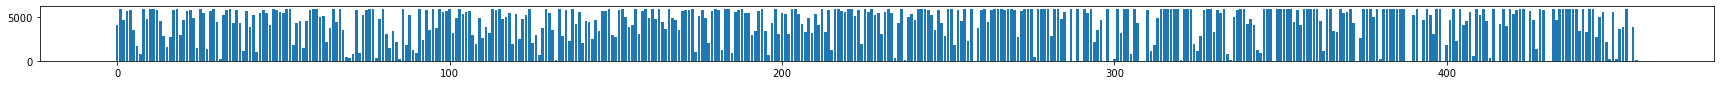

5918
(6265, 458)
how many unique paths in the filtered pattern? (41, 76)
[286 288 297 299 308 335 373 388 389 392 399 430  23  26  29  45  61 105
 117 159 176 190 253 256 257 259 261 265 268 269 273 275 280 284 294 298
 306 307 310 314 315 322 331 333 334 347 350 352 355 356 358 361 369 370
 371 376 378 379 382 391 393 394 395 400 405 407 416 417 421 426 428 433
 439 441 442 447]


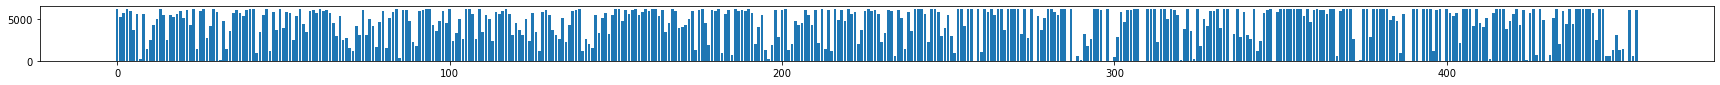

6265
(5851, 458)
how many unique paths in the filtered pattern? (50, 121)
[258 286 288 297 299 308 309 335 348 373 388 389 392 399 424 430 431  28
  29  44  45  47  59  67  80 109 115 129 146 151 156 158 159 161 173 186
 188 216 220 221 227 232 241 250 257 261 262 264 265 266 267 268 269 273
 275 277 280 282 283 287 293 298 304 310 314 315 317 318 319 321 322 327
 331 333 337 339 346 347 349 350 351 352 353 355 356 357 358 359 360 361
 364 365 368 369 371 375 376 378 382 384 385 387 391 394 397 398 405 407
 409 414 416 420 422 423 432 434 436 437 439 441 447]


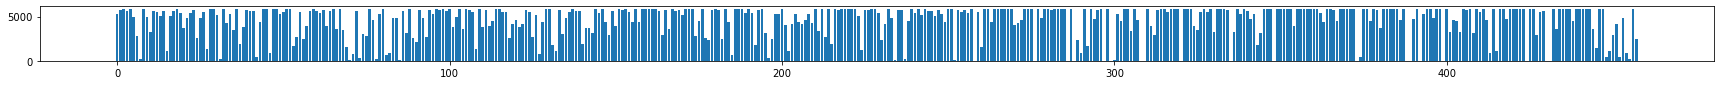

5851
(5949, 458)
how many unique paths in the filtered pattern? (58, 102)
[258 286 288 297 299 308 309 335 348 373 388 389 392 399 424 430 431  29
  52  61  80  91 100 109 115 156 159 161 162 176 186 216 220 226 241 253
 254 259 265 268 269 273 275 280 281 284 295 298 304 307 310 314 315 317
 318 322 331 333 346 347 349 350 351 352 353 355 356 357 358 361 365 366
 368 370 371 375 376 378 379 381 382 390 391 393 394 395 397 400 405 407
 409 416 417 421 423 426 435 439 440 441 443 447]


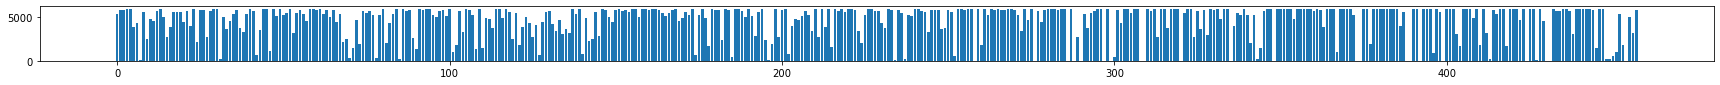

5949
{288, 322, 389, 392, 265, 361, 299, 269, 430, 399, 273, 315, 373, 314, 347} 15


In [99]:
all_stable_relus = []
epsilon = 0.001
for label in all_patterns:
    patterns = all_patterns[label]
    print(patterns.shape)
    
    
    relu_sum = np.sum(patterns, axis = 0).squeeze()

    stable_idx = np.concatenate([np.where(relu_sum<=epsilon*patterns.shape[0]), 
                                 np.where(relu_sum>=(1-epsilon)*patterns.shape[0])],
                                axis = 1
                                ).squeeze()
    print("how many unique paths in the filtered pattern?", np.unique(patterns[:, stable_idx ], axis = 0).shape)

    all_stable_relus.append(set(stable_idx))           
    print(stable_idx)
    fig = plt.figure(figsize=(30, 1))
    plt.bar(range(458), relu_sum)
    plt.show()
    print(relu_sum.max())
    
super_stable = set.intersection(*all_stable_relus)
print(super_stable, len(super_stable))

In [102]:
label = 1

stable_idx = np.array(sorted(all_stable_relus[label]))

patterns = []
for data, target in test_loader:
    filter_ids = target == label
    data = data[filter_ids]
    logging.debug(data.shape[0])
    pattern = CFI_utils.get_pattern(model, device, data)
    pattern = np.concatenate([pattern[l] for l in layers], axis = 1)
    logging.debug(pattern.shape)
    patterns.append(pattern)

test_patterns = np.concatenate(patterns, axis = 0)
logging.info(test_patterns.shape)
print("LABEL:", label)
print("how many unique paths in the full pattern?", np.unique(test_patterns, axis = 0).shape)
print("how many unique paths in the filtered pattern?", np.unique(test_patterns[:, stable_idx ], axis = 0).shape)
print("how many unique paths in the randomly filtered pattern?", 
      np.unique(test_patterns[:, 
                         np.random.choice(458, len(stable_idx), replace = False) ], axis = 0).shape)




train_patterns = all_patterns[label]
raw_train_patterns = np.unique(train_patterns[:, stable_idx], axis = 0)
print(raw_train_patterns.shape)

raw_test_patterns = np.unique(test_patterns[:, stable_idx], axis = 0)
print(raw_test_patterns.shape)

set_train_patterns = set([tuple(p) for p in raw_train_patterns])
set_test_patterns = set([tuple(p) for p in raw_test_patterns])

print(len(set_train_patterns), len(set_test_patterns))
print(len(set_train_patterns.intersection(set_test_patterns)))

root - INFO - (1135, 458)


LABEL: 1
how many unique paths in the full pattern? (1135, 458)
how many unique paths in the filtered pattern? (11, 142)
how many unique paths in the randomly filtered pattern? (1122, 142)
(51, 142)
(11, 142)
51 11
5


# RQ6:study the hot ReLU and the gradient
Do at least the following statistics on the activation patterns.
- What are the top k RELU with the highest gradient value (indicating that they are highly influential ReLU). If we only look at those ReLU, how many activation patterns do we have? This exp should be parametrized by k
- For activation patterns from images from the same label (e.g 7), what ReLU are stable, and what not? To check for stable, we set a threshold T%. If the value of the ith ReLU is the same for at least T% of the time, we say that ith ReLU is stable.
- Given that ith ReLU is stable for the label 7, is it also stable for a different label (e.g 9)? Note that for label 7, it may stable and always be 1, but for label 9, it may also be stable but with value 0.


#Checking ReLUs with highest gradient

